## Final Project Submission

Please fill out:
* Student name: Daniel Quillao
* Student pace: Self-paced
* Scheduled project review date/time: 4/13/21 at 2PM PST
* Instructor name: Jeff Herman
* Blog post URL: https://dquillao.github.io/mod_2_project_feature_engineering_zipcodes

# 1. Obtain Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

import scipy.stats as stats

import pickle

In [2]:
df = pd.read_csv('kc_house_data.csv')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


# 2. Scrub and Clean Data

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

## Check for erroneous values

In [4]:
# Preview the 5 most frequent entries from each column
for col in df.columns:
    try:
        print(col, df[col].value_counts()[:5])
    except:
        print(col, df[col].value_counts())
        # If there aren't 5+ unique values for a column the first print statement
        # will throw an error for an invalid idx slice
    print('\n') # Break up the output between columns

id 795000620     3
1825069031    2
2019200220    2
7129304540    2
1781500435    2
Name: id, dtype: int64


date 6/23/2014    142
6/26/2014    131
6/25/2014    131
7/8/2014     127
4/27/2015    126
Name: date, dtype: int64


price 350000.0    172
450000.0    172
550000.0    159
500000.0    152
425000.0    150
           ... 
870515.0      1
336950.0      1
386100.0      1
176250.0      1
884744.0      1
Name: price, Length: 3622, dtype: int64


bedrooms 3    9824
4    6882
2    2760
5    1601
6     272
Name: bedrooms, dtype: int64


bathrooms 2.50    5377
1.00    3851
1.75    3048
2.25    2047
2.00    1930
1.50    1445
2.75    1185
3.00     753
3.50     731
3.25     589
3.75     155
4.00     136
4.50     100
4.25      79
0.75      71
4.75      23
5.00      21
Name: bathrooms, dtype: int64


sqft_living 1300    138
1400    135
1440    133
1660    129
1010    129
Name: sqft_living, dtype: int64


sqft_lot 5000    358
6000    290
4000    251
7200    220
7500    119
Name: sqft_lot, dtype: 

Notes: sqft_basement change to float, update '?' values

In [5]:
# sqft_basement: check for instances of '?'
df['sqft_basement'].value_counts()

0.0       12826
?           454
600.0       217
500.0       209
700.0       208
          ...  
2050.0        1
602.0         1
417.0         1
3260.0        1
2400.0        1
Name: sqft_basement, Length: 304, dtype: int64

In [6]:
# Drop rows as it only accounts for 2% of the data
df = df.drop(df[df['sqft_basement']=='?'].index)

In [7]:
df['sqft_basement'] = pd.to_numeric(df['sqft_basement'])

## Check for nulls

In [8]:
# Check sum of nulls
df.isna().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2339
view               61
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3754
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

Note: Check waterfront, view, and yr_renovated

In [9]:
# Get statistics
df[['waterfront', 'view', 'yr_renovated']].describe()

,waterfront,view,yr_renovated
count,18804.000000,21082.000000,17389.000000
mean,0.007552,0.233327,82.991949
std,0.086573,0.765066,398.481819
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000
max,1.000000,4.000000,2015.000000


In [10]:
null_list = ['waterfront', 'view', 'yr_renovated']

for feature in null_list:
    print(df[feature].value_counts())

0.0    18662
1.0      142
Name: waterfront, dtype: int64
0.0    19018
2.0      930
3.0      496
1.0      327
4.0      311
Name: view, dtype: int64
0.0       16666
2014.0       69
2003.0       31
2013.0       31
2007.0       30
          ...  
1953.0        1
1944.0        1
1934.0        1
1971.0        1
1959.0        1
Name: yr_renovated, Length: 69, dtype: int64


Notes:
- waterfront has 2339 null values
- view has 61 null values
- yr_renovated has 3754 null values
- The majority of the data is 0 for these features. Update null values to 0.

In [11]:
# Update null values to 0
df.fillna(0, inplace = True)

In [12]:
# Double-check for null values
df.isna().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

In [13]:
# Check for duplicates
print(len(df[df.duplicated()]))

0


# 4. Explore Data

## Feature Engineering

Notes:
- yr_renovated: convert to binary {0: not renovated, 1: renovated}
- sqft_basement: convert to binary {0: no basement, 1: has basement}
- waterfront: convert to binary {0: no waterfront, 1: has waterfront}
- date and id: not useful, drop
- lat and long: should be categorical, however might be better to drop (i think zip code will be a similar/better feauture)
- convert zip code to priced tier ranks (1-10)

In [14]:
# yr_renovated
df['yr_renovated'].value_counts()

0.0       20420
2014.0       69
2003.0       31
2013.0       31
2007.0       30
          ...  
1953.0        1
1944.0        1
1934.0        1
1971.0        1
1959.0        1
Name: yr_renovated, Length: 69, dtype: int64

In [15]:
# Create new column renovated
df['renovated'] = df['yr_renovated'].map(lambda x: 1 if x > 0 else 0)
# Drop yr_renovated column
df = df.drop('yr_renovated', axis=1)

In [16]:
# Check new column
df['renovated'].value_counts()

0    20420
1      723
Name: renovated, dtype: int64

In [17]:
# sqft_basement
df['sqft_basement'].value_counts()

0.0       12826
600.0       217
500.0       209
700.0       208
800.0       201
          ...  
915.0         1
295.0         1
1281.0        1
2130.0        1
906.0         1
Name: sqft_basement, Length: 303, dtype: int64

In [18]:
# Create new column basement
df['basement'] = df['sqft_basement'].map(lambda x: 1 if x > 0 else 0)
# Drop sqft_basement column
df = df.drop('sqft_basement', axis=1)

In [19]:
# Check new column
df['basement'].value_counts()

0    12826
1     8317
Name: basement, dtype: int64

In [20]:
# view
df['view'].value_counts()

0.0    19079
2.0      930
3.0      496
1.0      327
4.0      311
Name: view, dtype: int64

In [21]:
# Update view
df['view'] = df['view'].map(lambda x: 1 if x > 0 else 0)

In [22]:
# Check view
df['view'].value_counts()

0    19079
1     2064
Name: view, dtype: int64

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21143 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21143 non-null  int64  
 1   date           21143 non-null  object 
 2   price          21143 non-null  float64
 3   bedrooms       21143 non-null  int64  
 4   bathrooms      21143 non-null  float64
 5   sqft_living    21143 non-null  int64  
 6   sqft_lot       21143 non-null  int64  
 7   floors         21143 non-null  float64
 8   waterfront     21143 non-null  float64
 9   view           21143 non-null  int64  
 10  condition      21143 non-null  int64  
 11  grade          21143 non-null  int64  
 12  sqft_above     21143 non-null  int64  
 13  yr_built       21143 non-null  int64  
 14  zipcode        21143 non-null  int64  
 15  lat            21143 non-null  float64
 16  long           21143 non-null  float64
 17  sqft_living15  21143 non-null  int64  
 18  sqft_l

In [24]:
# waterfront
df['waterfront'].value_counts()

0.0    21001
1.0      142
Name: waterfront, dtype: int64

In [25]:
# Update waterfront
df['waterfront'] = df['waterfront'].map(lambda x: 1 if x > 0 else 0)

In [26]:
# Check waterfront
df['waterfront'].value_counts()

0    21001
1      142
Name: waterfront, dtype: int64

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21143 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21143 non-null  int64  
 1   date           21143 non-null  object 
 2   price          21143 non-null  float64
 3   bedrooms       21143 non-null  int64  
 4   bathrooms      21143 non-null  float64
 5   sqft_living    21143 non-null  int64  
 6   sqft_lot       21143 non-null  int64  
 7   floors         21143 non-null  float64
 8   waterfront     21143 non-null  int64  
 9   view           21143 non-null  int64  
 10  condition      21143 non-null  int64  
 11  grade          21143 non-null  int64  
 12  sqft_above     21143 non-null  int64  
 13  yr_built       21143 non-null  int64  
 14  zipcode        21143 non-null  int64  
 15  lat            21143 non-null  float64
 16  long           21143 non-null  float64
 17  sqft_living15  21143 non-null  int64  
 18  sqft_l

In [28]:
# Drop unnecessary columns
#df.drop(columns=['date', 'id', 'lat', 'long'], inplace=True) 

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21143 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21143 non-null  int64  
 1   date           21143 non-null  object 
 2   price          21143 non-null  float64
 3   bedrooms       21143 non-null  int64  
 4   bathrooms      21143 non-null  float64
 5   sqft_living    21143 non-null  int64  
 6   sqft_lot       21143 non-null  int64  
 7   floors         21143 non-null  float64
 8   waterfront     21143 non-null  int64  
 9   view           21143 non-null  int64  
 10  condition      21143 non-null  int64  
 11  grade          21143 non-null  int64  
 12  sqft_above     21143 non-null  int64  
 13  yr_built       21143 non-null  int64  
 14  zipcode        21143 non-null  int64  
 15  lat            21143 non-null  float64
 16  long           21143 non-null  float64
 17  sqft_living15  21143 non-null  int64  
 18  sqft_l

## Tranform zipcode in price tier ranks (1-10)

In [30]:
df.zipcode.value_counts()

98103    588
98038    574
98115    568
98052    562
98042    542
        ... 
98102    100
98010     98
98024     79
98148     55
98039     49
Name: zipcode, Length: 70, dtype: int64

In [31]:
# Create copy
rank_df = df.copy()

In [32]:
# Groupby zipcode and take median price
zip_med_df = rank_df.groupby(rank_df['zipcode'])['price'].median().sort_values(ascending = False)

# Reset index after groupy
zip_med_df = zip_med_df.reset_index()

# Set as string to match
zip_med_df['zipcode'] = zip_med_df['zipcode'].astype('object')

zip_med_df.head(10)

,zipcode,price
0,98039,1880000.0
1,98004,1150000.0
2,98040,994000.0
3,98112,920000.0
4,98005,762450.0
5,98006,760184.5
6,98119,750000.0
7,98075,745000.0
8,98109,736000.0
9,98102,695000.0


In [33]:
# https://stackoverflow.com/questions/60255203/how-to-label-every-nth-row-of-a-pandas-dataframe-by-an-incremental-value
zip_med_df['rank'] = np.divmod(np.arange(len(zip_med_df)),7)[0]+1

In [34]:
zip_med_df.head(21)

,zipcode,price,rank
0,98039,1880000.0,1
1,98004,1150000.0,1
2,98040,994000.0,1
3,98112,920000.0,1
4,98005,762450.0,1
5,98006,760184.5,1
6,98119,750000.0,1
7,98075,745000.0,2
8,98109,736000.0,2
9,98102,695000.0,2


In [35]:
zip_med_df.groupby(['rank'])['price'].median()

rank
1     920000.0
2     689900.0
3     575000.0
4     550000.0
5     470000.0
6     425000.0
7     375250.0
8     315000.0
9     279500.0
10    260000.0
Name: price, dtype: float64

In [36]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15,renovated,basement
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,1955,98178,47.5112,-122.257,1340,5650,0,0
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,1951,98125,47.7210,-122.319,1690,7639,1,1
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,1933,98028,47.7379,-122.233,2720,8062,0,0
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,1965,98136,47.5208,-122.393,1360,5000,0,1
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,1987,98074,47.6168,-122.045,1800,7503,0,0


In [37]:
zip_med_df.drop(['price'], axis = 1, inplace = True)

In [38]:
df = pd.merge(df, zip_med_df, on='zipcode')

In [39]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_above,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15,renovated,basement,rank
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,0,0,...,1180,1955,98178,47.5112,-122.257,1340,5650,0,0,9
1,4060000240,6/23/2014,205425.0,2,1.00,880,6780,1.0,0,0,...,880,1945,98178,47.5009,-122.248,1190,6780,0,0,9
2,4058801670,7/17/2014,445000.0,3,2.25,2100,8201,1.0,0,1,...,1620,1967,98178,47.5091,-122.244,2660,8712,0,1,9
3,2976800796,9/25/2014,236000.0,3,1.00,1300,5898,1.0,0,0,...,1300,1961,98178,47.5053,-122.255,1320,7619,0,0,9
4,6874200960,2/27/2015,170000.0,2,1.00,860,5265,1.0,0,0,...,860,1931,98178,47.5048,-122.272,1650,8775,0,0,9


In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21143 entries, 0 to 21142
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21143 non-null  int64  
 1   date           21143 non-null  object 
 2   price          21143 non-null  float64
 3   bedrooms       21143 non-null  int64  
 4   bathrooms      21143 non-null  float64
 5   sqft_living    21143 non-null  int64  
 6   sqft_lot       21143 non-null  int64  
 7   floors         21143 non-null  float64
 8   waterfront     21143 non-null  int64  
 9   view           21143 non-null  int64  
 10  condition      21143 non-null  int64  
 11  grade          21143 non-null  int64  
 12  sqft_above     21143 non-null  int64  
 13  yr_built       21143 non-null  int64  
 14  zipcode        21143 non-null  object 
 15  lat            21143 non-null  float64
 16  long           21143 non-null  float64
 17  sqft_living15  21143 non-null  int64  
 18  sqft_l

In [41]:
df.sort_values('price')

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_above,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15,renovated,basement,rank
16736,40000362,5/6/2014,78000.0,2,1.00,780,16344,1.0,0,0,...,780,1942,98168,47.4739,-122.280,1700,10387,0,0,10
20712,8658300340,5/23/2014,80000.0,1,0.75,430,5050,1.0,0,0,...,430,1912,98014,47.6499,-121.909,1200,7500,0,0,6
16746,3028200080,3/24/2015,81000.0,2,1.00,730,9975,1.0,0,0,...,730,1943,98168,47.4808,-122.315,860,9000,0,0,10
2393,3883800011,11/5/2014,82000.0,3,1.00,860,10426,1.0,0,0,...,860,1954,98146,47.4987,-122.341,1140,11250,0,0,8
16567,1623049041,5/8/2014,82500.0,2,1.00,520,22334,1.0,0,0,...,520,1951,98168,47.4799,-122.296,1572,10570,0,0,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13241,8907500070,4/13/2015,5350000.0,5,5.00,8000,23985,2.0,0,1,...,6720,2009,98004,47.6232,-122.220,4600,21750,0,1,1
21099,2470100110,8/4/2014,5570000.0,5,5.75,9200,35069,2.0,0,0,...,6200,2001,98039,47.6289,-122.233,3560,24345,0,1,1
21106,9208900037,9/19/2014,6890000.0,6,7.75,9890,31374,2.0,0,1,...,8860,2001,98039,47.6305,-122.240,4540,42730,0,1,1
13284,9808700762,6/11/2014,7060000.0,5,4.50,10040,37325,2.0,1,1,...,7680,1940,98004,47.6500,-122.214,3930,25449,1,1,1


## Check for outliers

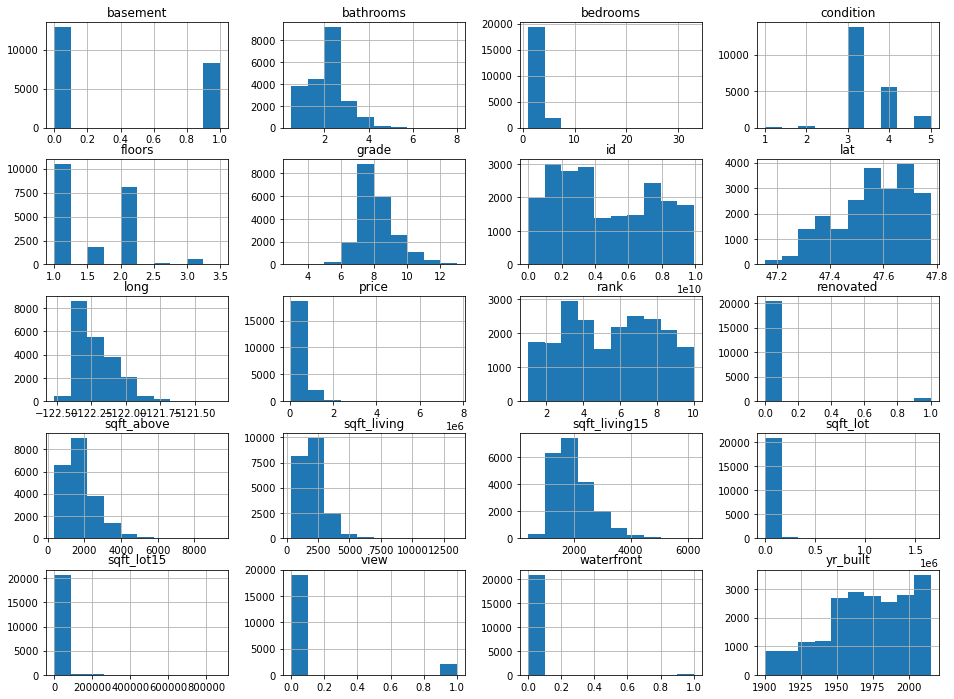

In [42]:
df.hist(figsize=(16, 12));

In [43]:
# Removes feats with z-score above 3 for specific columns
# Reference https://stackoverflow.com/questions/23199796/detect-and-exclude-outliers-in-pandas-data-frame

outlier_feats = ['price', 'sqft_living', 'sqft_living15', 'sqft_lot', 'sqft_lot15', 'sqft_above', 'bathrooms', 'bedrooms', 'floors']

for feat in outlier_feats:
    df = df[np.abs(df[feat]-df[feat].mean()) <= (3*df[feat].std())]

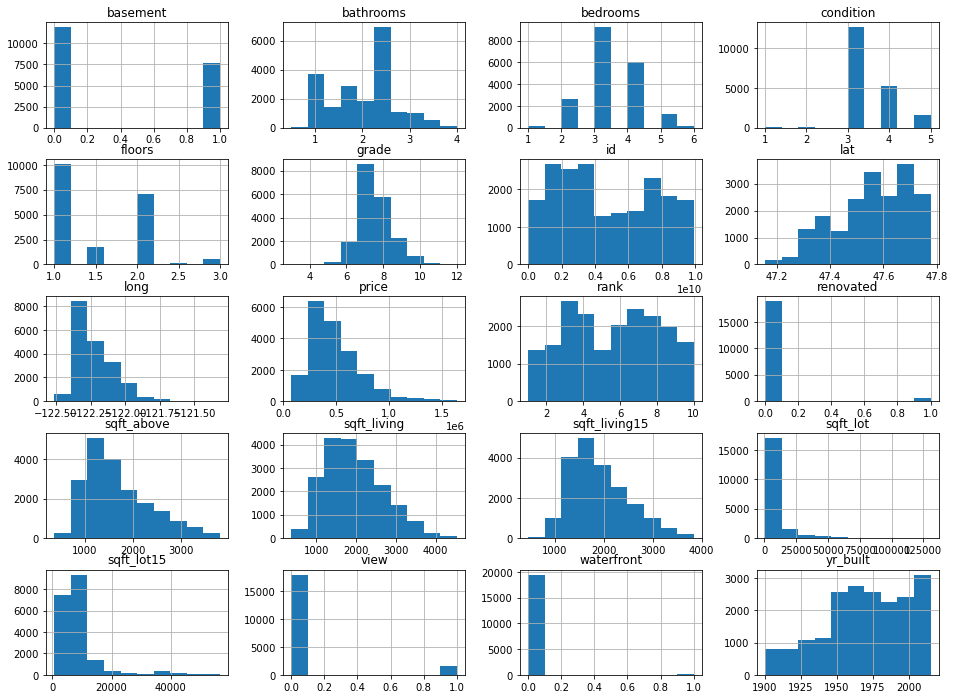

In [44]:
df.hist(figsize=(16,12));

In [45]:
df.floors.value_counts()

1.0    10054
2.0     7061
1.5     1752
3.0      564
2.5      114
Name: floors, dtype: int64

In [46]:
df.bedrooms.value_counts()

3    9220
4    6058
2    2614
5    1274
6     196
1     183
Name: bedrooms, dtype: int64

In [47]:
df.bathrooms.value_counts()

2.50    4976
1.00    3694
1.75    2900
2.25    1930
2.00    1816
1.50    1394
2.75    1069
3.00     646
3.50     512
3.25     400
3.75      75
0.75      67
4.00      54
1.25       9
0.50       3
Name: bathrooms, dtype: int64

## Visualize zip codes

In [48]:
# find map center using lat and long
def get_center_latlong(df):
    # get the center of my map for plotting
    centerlat = (df['lat'].max() + df['lat'].min()) / 2
    centerlong = (df['long'].max() + df['long'].min()) / 2
    return centerlat, centerlong

In [49]:
import folium

# grab the center of our map using function
center = get_center_latlong(df)

# create a new map object
m = folium.Map(location=center, zoom_start=10)

# save our map to an interactive html file
m.save('circle_map.html')

In [50]:
import branca.colormap as cm

# create a LinearColorMap and assign colors, vmin, and vmax
# the colormap will show green for $100,000 homes all the way up to red for $1,500,000 homes
colormap = cm.LinearColormap(colors=['green', 'yellow', 'red'], vmin=100000, vmax=1500000)

# create our map again.  This time I am using a different tileset for a new look
m = folium.Map(location=center, zoom_start=10, tiles='Stamen Toner')

# Same as before... go through each home in set, make circle, and add to map.
# This time we add a color using price and the colormap object
for i in range(len(df)):
    folium.Circle(
        location=[df.iloc[i]['lat'], df.iloc[i]['long']],
        radius=10,
        fill=True,
        color=colormap(df.iloc[i]['price']),
        fill_opacity=0.2
    ).add_to(m)

# the following line adds the scale directly to our map
m.add_child(colormap)

# Save map 
m.save('price_colormap.html')

In [51]:
price_max = df.price.max()
price_max

1640000.0

In [52]:
price_min = df.price.min()
price_min

78000.0

## Check for linearity: Joint Plots

/Users/daniel/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:1840: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))
/Users/daniel/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:1840: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))
/Users/daniel/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:1840: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))
/Users/daniel/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:1840: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))
/Users/daniel/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:1840: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warning

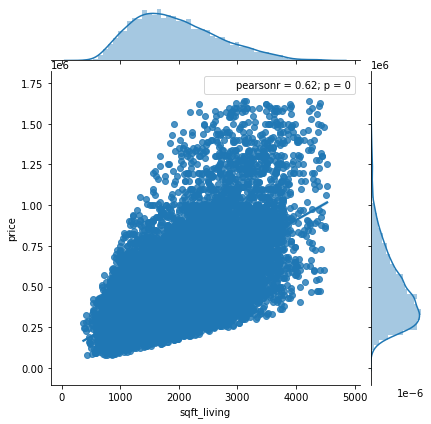

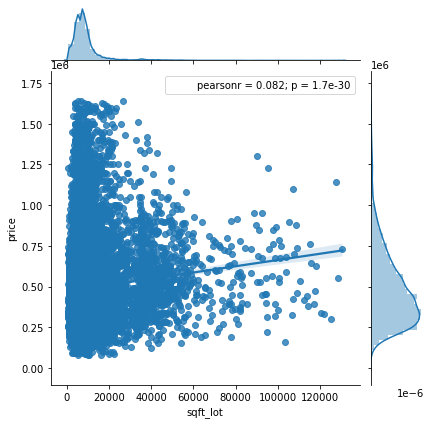

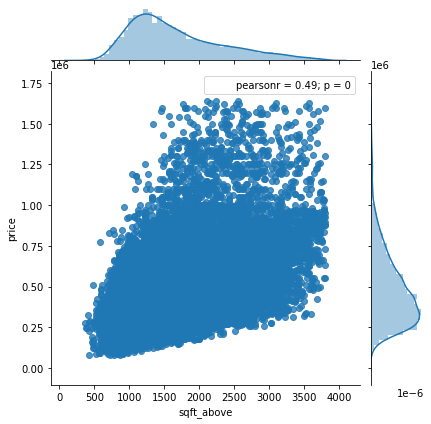

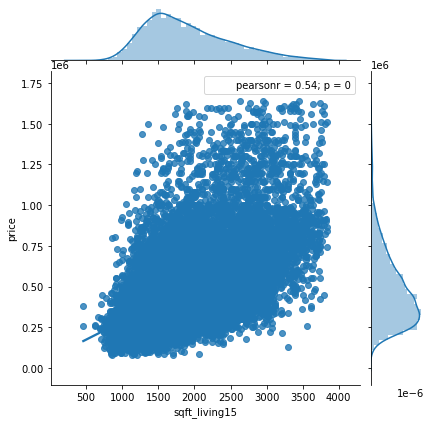

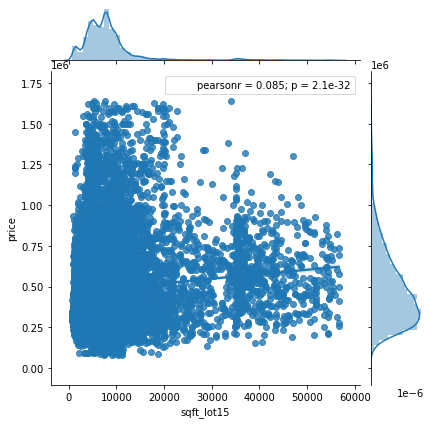

In [53]:
# Plot joint plots
joint_feats = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_living15', 'sqft_lot15']

for feat in joint_feats:
    j = sns.jointplot(x = df[feat], y = df['price'], kind = 'reg')
    j.annotate(stats.pearsonr)

Note: sqft_living, sqft_above, and sqft_living15 have a moderate linear relationship with price

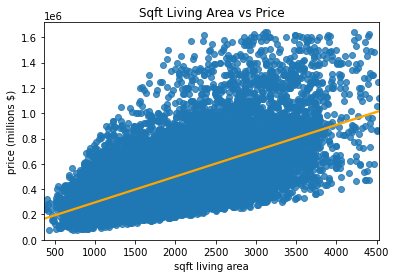

In [54]:
x = df['sqft_living']
y = df['price']

ax = sns.regplot(x, y, line_kws={"color": "orange"})
plt.xlabel('sqft living area')
plt.ylabel('price (millions $)')
plt.title('Sqft Living Area vs Price')
plt.show()

## Check for linearity: Box Plots

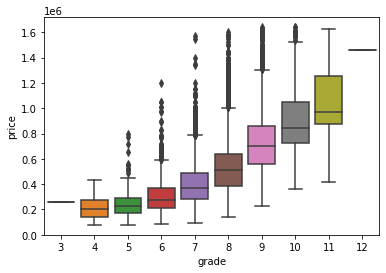

In [55]:
sns.boxplot(x = df['grade'], y = df['price'])

Note: Strong relationship with price

In [56]:
median_grade = df.groupby('grade')['price'].median().reset_index()
median_grade

,grade,price
0,3,262000.0
1,4,200000.0
2,5,225000.0
3,6,275000.0
4,7,373000.0
5,8,509975.0
6,9,700500.0
7,10,845800.0
8,11,973900.0
9,12,1460000.0


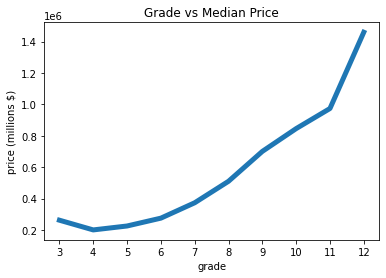

In [57]:
fig = sns.lineplot(x = 'grade', y = 'price', data = median_grade, lw=5)
plt.xlabel('grade')
plt.ylabel('price (millions $)')
plt.xticks(range(3,13))
plt.title('Grade vs Median Price')
plt.show()

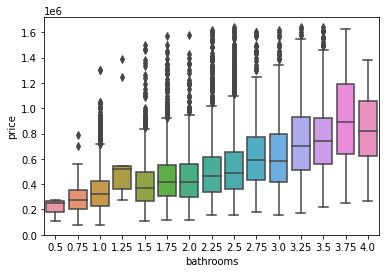

In [58]:
sns.boxplot(x = df['bathrooms'], y = df['price'])

Note: Strong relationship with price

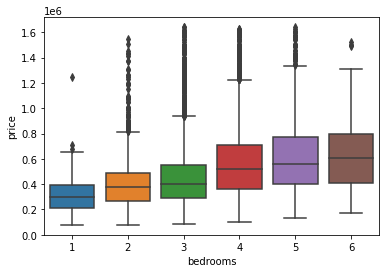

In [59]:
sns.boxplot(x = df['bedrooms'], y = df['price'])

Note: Moderate relationship with price

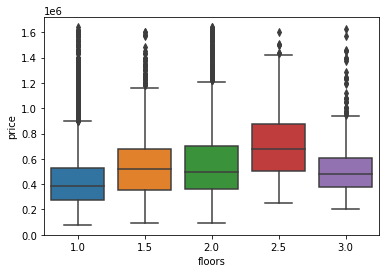

In [60]:
sns.boxplot(x = df['floors'], y = df['price'])

Note: Not much of a relationship with price

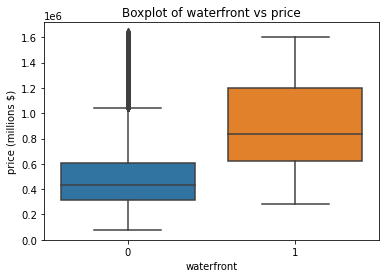

In [61]:
sns.boxplot(x = df['waterfront'], y = df['price'])
plt.title('Boxplot of waterfront vs price');
plt.ylabel('price (millions $)');

In [62]:
median_waterfront = df.groupby('waterfront')['price'].median().reset_index()
median_waterfront

,waterfront,price
0,0,435000.0
1,1,835000.0


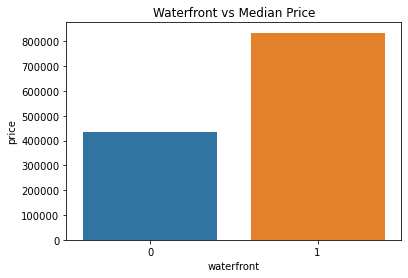

In [63]:
fig = sns.barplot(x = 'waterfront', y = 'price', data = median_waterfront)
plt.xlabel('waterfront')
plt.ylabel('price')
plt.title('Waterfront vs Median Price')
plt.show()

Note: Strong relationship with price

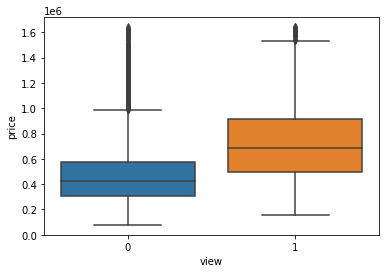

In [64]:
sns.boxplot(x = df['view'], y = df['price'])

Note: Moderate relationship with price

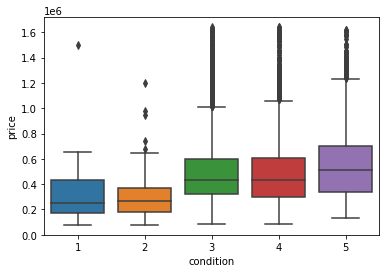

In [65]:
sns.boxplot(x = df['condition'], y = df['price'])

Note: Not much of a relationship with price. Looks like there's an outlier as well in Condition 1.

In [66]:
# con_out_df = df[['condition', 'price']]

In [67]:
# con_1_df = con_out_df[con_out_df['condition'] == 1]
# con_1_df.describe()

In [68]:
# row_to_drop = con_out_df[(con_out_df['condition'] == 1) & (con_out_df['price'] >= 1500000)]

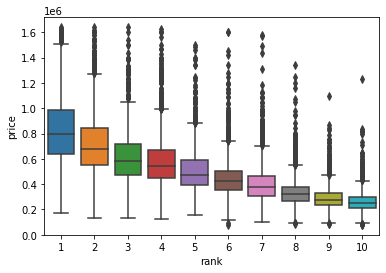

In [69]:
sns.boxplot(x = df['rank'], y = df['price'])

Note: Strong relationship with price

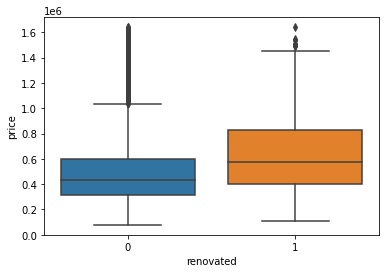

In [70]:
sns.boxplot(x = df['renovated'], y = df['price'])

Note: Not much of a relationship with price

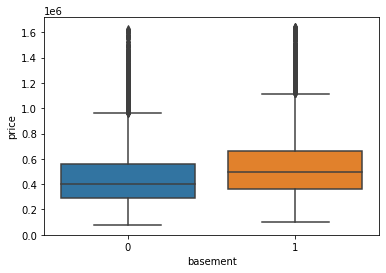

In [71]:
sns.boxplot(x = df['basement'], y = df['price'])

Note: Not much of a relationship with price

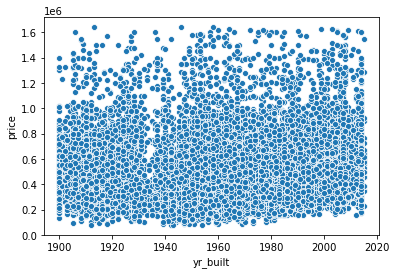

In [72]:
sns.scatterplot(x = df['yr_built'], y = df['price'])

Note: No relationship with price

In [73]:
# Drop unnecessary columns
df.drop(columns=['date', 'id', 'lat', 'long'], inplace=True) 

## Normalize Continuous Features

In [74]:
# Log transform to reduce skewness
# Remember that you can't take the logarithm of zero nor a negative number
log_feats = ['price', 'sqft_living', 'sqft_living15', 'sqft_lot', 'sqft_lot15', 'sqft_above', 'bedrooms', 'bathrooms', 'floors']
for var in log_feats:
    df[var]= np.log(df[var])

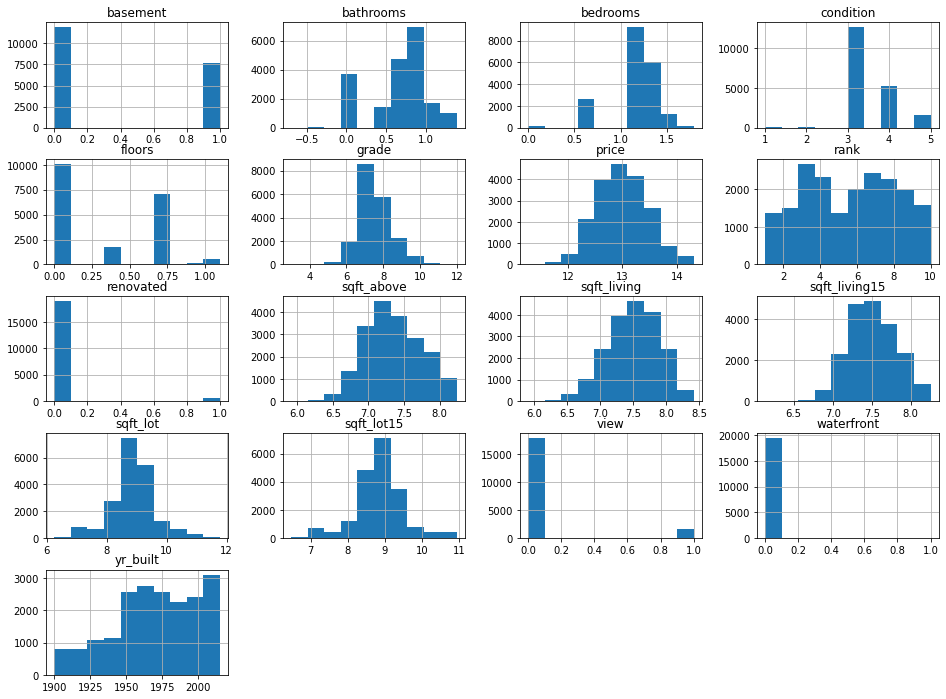

In [75]:
df.hist(figsize = (16,12));

In [76]:
# Standardization (z-score normalization)
# x' will have mean  𝜇=0  and  𝜎=1 
# Note that standardization does not make data more normal, it will just change the mean and the standard error

continuous_feats = ['price', 'sqft_living', 'sqft_living15', 'sqft_lot', 'sqft_lot15', 'sqft_above', 'bedrooms', 'bathrooms', 'floors']

for var in continuous_feats:
    df[var] = (df[var] - df[var].mean()) / df[var].std()

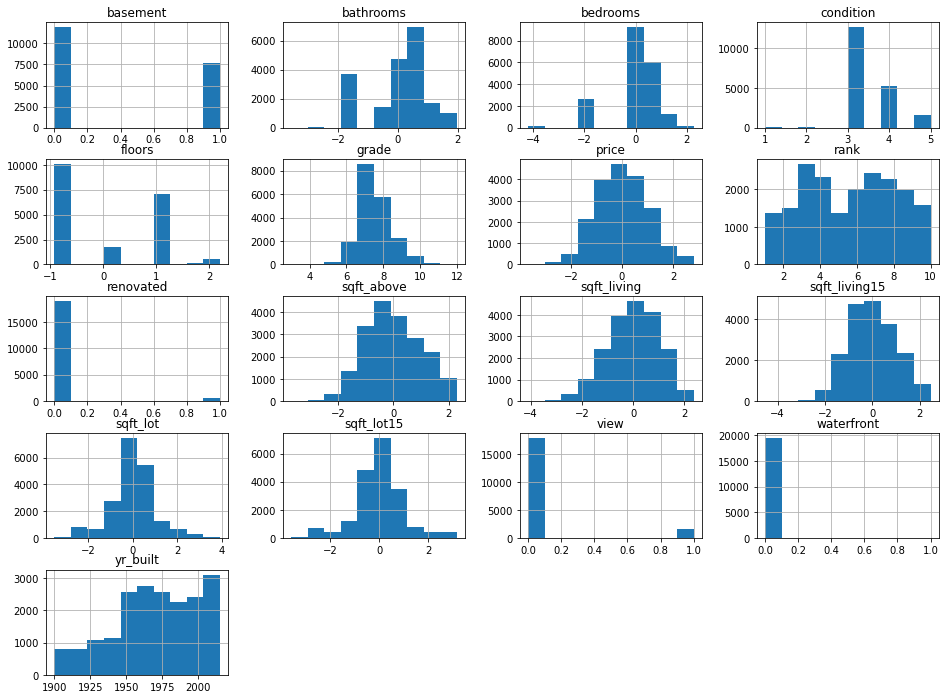

In [77]:
df.hist(figsize = (16, 12));

In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19545 entries, 0 to 21135
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          19545 non-null  float64
 1   bedrooms       19545 non-null  float64
 2   bathrooms      19545 non-null  float64
 3   sqft_living    19545 non-null  float64
 4   sqft_lot       19545 non-null  float64
 5   floors         19545 non-null  float64
 6   waterfront     19545 non-null  int64  
 7   view           19545 non-null  int64  
 8   condition      19545 non-null  int64  
 9   grade          19545 non-null  int64  
 10  sqft_above     19545 non-null  float64
 11  yr_built       19545 non-null  int64  
 12  zipcode        19545 non-null  object 
 13  sqft_living15  19545 non-null  float64
 14  sqft_lot15     19545 non-null  float64
 15  renovated      19545 non-null  int64  
 16  basement       19545 non-null  int64  
 17  rank           19545 non-null  int64  
dtypes: flo

## Check for multicollinearity

In [79]:
corr = df.corr()
corr

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,sqft_living15,sqft_lot15,renovated,basement,rank
price,1.000000,0.298117,0.450068,0.604596,0.037859,0.286331,0.076759,0.266107,0.058972,0.630984,0.497917,0.036645,0.545650,0.029140,0.096071,0.219348,-0.728044
bedrooms,0.298117,1.000000,0.506614,0.646211,0.222292,0.186379,-0.036719,0.041952,0.036387,0.353718,0.532583,0.191406,0.409192,0.204570,-0.001804,0.150689,-0.038534
bathrooms,0.450068,0.506614,1.000000,0.730022,0.001110,0.497049,-0.002394,0.097409,-0.106817,0.607445,0.642845,0.542441,0.534422,0.002558,0.028008,0.166559,-0.156479
sqft_living,0.604596,0.646211,0.730022,1.000000,0.273918,0.361925,0.011712,0.180861,-0.034465,0.689984,0.836282,0.337518,0.717285,0.253959,0.036595,0.248286,-0.195502
sqft_lot,0.037859,0.222292,0.001110,0.273918,1.000000,-0.319744,0.058261,0.077048,0.119170,0.084570,0.250870,-0.078134,0.336251,0.909960,0.014911,-0.042802,0.118505
floors,0.286331,0.186379,0.497049,0.361925,-0.319744,1.000000,-0.000430,-0.016783,-0.263562,0.460495,0.570358,0.480538,0.270249,-0.307429,0.003356,-0.277706,-0.150594
waterfront,0.076759,-0.036719,-0.002394,0.011712,0.058261,-0.000430,1.000000,0.190964,0.005129,0.006973,-0.000167,-0.033047,0.031520,0.068679,0.066349,0.017251,0.019753
view,0.266107,0.041952,0.097409,0.180861,0.077048,-0.016783,0.190964,1.000000,0.044877,0.164738,0.081103,-0.086481,0.215955,0.073973,0.069704,0.181091,-0.058127
condition,0.058972,0.036387,-0.106817,-0.034465,0.119170,-0.263562,0.005129,0.044877,1.000000,-0.149007,-0.144694,-0.354071,-0.083167,0.124593,-0.057038,0.131149,-0.034039
grade,0.630984,0.353718,0.607445,0.689984,0.084570,0.460495,0.006973,0.164738,-0.149007,1.000000,0.692376,0.459888,0.641103,0.098060,0.005771,0.041720,-0.330802


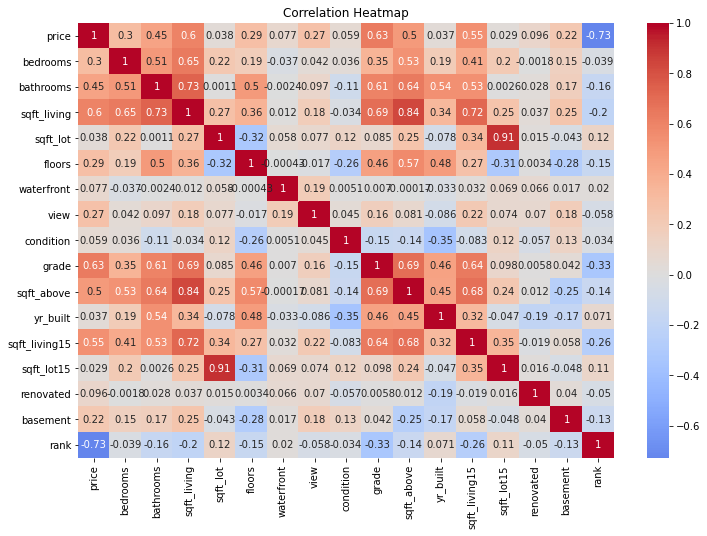

In [80]:
# Plot heatmap
plt.figure(figsize = (12,8))
sns.heatmap(corr, center = 0, annot = True, cmap = 'coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [81]:
corr

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,sqft_living15,sqft_lot15,renovated,basement,rank
price,1.000000,0.298117,0.450068,0.604596,0.037859,0.286331,0.076759,0.266107,0.058972,0.630984,0.497917,0.036645,0.545650,0.029140,0.096071,0.219348,-0.728044
bedrooms,0.298117,1.000000,0.506614,0.646211,0.222292,0.186379,-0.036719,0.041952,0.036387,0.353718,0.532583,0.191406,0.409192,0.204570,-0.001804,0.150689,-0.038534
bathrooms,0.450068,0.506614,1.000000,0.730022,0.001110,0.497049,-0.002394,0.097409,-0.106817,0.607445,0.642845,0.542441,0.534422,0.002558,0.028008,0.166559,-0.156479
sqft_living,0.604596,0.646211,0.730022,1.000000,0.273918,0.361925,0.011712,0.180861,-0.034465,0.689984,0.836282,0.337518,0.717285,0.253959,0.036595,0.248286,-0.195502
sqft_lot,0.037859,0.222292,0.001110,0.273918,1.000000,-0.319744,0.058261,0.077048,0.119170,0.084570,0.250870,-0.078134,0.336251,0.909960,0.014911,-0.042802,0.118505
floors,0.286331,0.186379,0.497049,0.361925,-0.319744,1.000000,-0.000430,-0.016783,-0.263562,0.460495,0.570358,0.480538,0.270249,-0.307429,0.003356,-0.277706,-0.150594
waterfront,0.076759,-0.036719,-0.002394,0.011712,0.058261,-0.000430,1.000000,0.190964,0.005129,0.006973,-0.000167,-0.033047,0.031520,0.068679,0.066349,0.017251,0.019753
view,0.266107,0.041952,0.097409,0.180861,0.077048,-0.016783,0.190964,1.000000,0.044877,0.164738,0.081103,-0.086481,0.215955,0.073973,0.069704,0.181091,-0.058127
condition,0.058972,0.036387,-0.106817,-0.034465,0.119170,-0.263562,0.005129,0.044877,1.000000,-0.149007,-0.144694,-0.354071,-0.083167,0.124593,-0.057038,0.131149,-0.034039
grade,0.630984,0.353718,0.607445,0.689984,0.084570,0.460495,0.006973,0.164738,-0.149007,1.000000,0.692376,0.459888,0.641103,0.098060,0.005771,0.041720,-0.330802


In [82]:
# save absolute value of correlation matrix as a data frame
# converts all values to absolute value
# stacks the row:column pairs into a multindex
# reset the index to set the multindex to seperate columns
# sort values. 0 is the column automatically generated by the stacking

df_abs = corr.abs().stack().reset_index().sort_values(0, ascending=False)

# zip the variable name columns (Which were only named level_0 and level_1 by default) in a new column named "pairs"
df_abs['pairs'] = list(zip(df_abs.level_0, df_abs.level_1))

# set index to pairs
df_abs.set_index(['pairs'], inplace = True)

#d rop level columns
df_abs.drop(columns=['level_1', 'level_0'], inplace = True)

# rename correlation column as cc rather than 0
df_abs.columns = ['cc']

# drop duplicates. This could be dangerous if you have variables perfectly correlated with variables other than themselves.
# for the sake of exercise, kept it in.
df_abs.drop_duplicates(inplace=True)

In [83]:
abs(df.corr()) > 0.75

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,sqft_living15,sqft_lot15,renovated,basement,rank
price,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
bedrooms,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
bathrooms,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
sqft_living,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False
sqft_lot,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False
floors,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
waterfront,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
view,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
condition,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
grade,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False


In [84]:
df_abs[(df_abs.cc>.75) & (df_abs.cc <1)]

,cc
pairs,
"(sqft_lot15, sqft_lot)",0.909960
"(sqft_above, sqft_living)",0.836282


In [85]:
df.drop(columns=['sqft_above', 'sqft_living15', 'sqft_lot15', 'zipcode'], inplace=True) 

In [86]:
df.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'yr_built', 'renovated',
       'basement', 'rank'],
      dtype='object')

In [87]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19545 entries, 0 to 21135
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   price        19545 non-null  float64
 1   bedrooms     19545 non-null  float64
 2   bathrooms    19545 non-null  float64
 3   sqft_living  19545 non-null  float64
 4   sqft_lot     19545 non-null  float64
 5   floors       19545 non-null  float64
 6   waterfront   19545 non-null  int64  
 7   view         19545 non-null  int64  
 8   condition    19545 non-null  int64  
 9   grade        19545 non-null  int64  
 10  yr_built     19545 non-null  int64  
 11  renovated    19545 non-null  int64  
 12  basement     19545 non-null  int64  
 13  rank         19545 non-null  int64  
dtypes: float64(6), int64(8)
memory usage: 2.9 MB


## One-hot encode Categorical Features

In [88]:
categorical_feats = ['view', 'basement', 'condition', 'grade', 'renovated', 'waterfront', 'yr_built', 'rank']

# Convert to str
for col in categorical_feats:
    df[col] = df[col].astype('str')   

In [89]:
df = pd.get_dummies(df, drop_first = True)

In [90]:
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront_1,view_1,condition_2,condition_3,...,basement_1,rank_10,rank_2,rank_3,rank_4,rank_5,rank_6,rank_7,rank_8,rank_9
0,-1.448625,-0.234561,-1.716352,-1.110551,-0.315715,-0.922555,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
1,-1.612827,-1.699959,-1.716352,-1.867599,-0.069677,-0.922555,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0.032464,-0.234561,0.437524,0.377035,0.187100,-0.922555,0,1,0,1,...,1,0,0,0,0,0,0,0,0,1
3,-1.317501,-0.234561,-1.716352,-0.860609,-0.257744,-0.922555,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
4,-2.015709,-1.699959,-1.716352,-1.926929,-0.410953,-0.922555,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1


Note: This is a lot of columns.

# 4. Model Data

## Model 1: All available features

Perform a train-test split and create an initial regression model to model the price using ALL available features

Note: In order to write the model you'll have to do some tedious manipulation of your column names. Statsmodels will not allow you to have spaces, apostrophe or arithmetic symbols (+) in your column names. Preview them and refine them as you go.
If you receive an error such as "PatsyError: error tokenizing input (maybe an unclosed string?)", then you need to further preprocess your column names.

In [91]:
subs = [(' ', '_'),('.','_'),("'",""),('™', ''), ('®',''),
        ('+','plus'), ('½','half'), ('-','_')
       ]
def col_formatting(col):
    for old, new in subs:
        col = col.replace(old,new)
    return col

In [92]:
df.columns = [col_formatting(col) for col in df.columns]

In [93]:
list(df.columns)

['price',
 'bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'waterfront_1',
 'view_1',
 'condition_2',
 'condition_3',
 'condition_4',
 'condition_5',
 'grade_11',
 'grade_12',
 'grade_3',
 'grade_4',
 'grade_5',
 'grade_6',
 'grade_7',
 'grade_8',
 'grade_9',
 'yr_built_1901',
 'yr_built_1902',
 'yr_built_1903',
 'yr_built_1904',
 'yr_built_1905',
 'yr_built_1906',
 'yr_built_1907',
 'yr_built_1908',
 'yr_built_1909',
 'yr_built_1910',
 'yr_built_1911',
 'yr_built_1912',
 'yr_built_1913',
 'yr_built_1914',
 'yr_built_1915',
 'yr_built_1916',
 'yr_built_1917',
 'yr_built_1918',
 'yr_built_1919',
 'yr_built_1920',
 'yr_built_1921',
 'yr_built_1922',
 'yr_built_1923',
 'yr_built_1924',
 'yr_built_1925',
 'yr_built_1926',
 'yr_built_1927',
 'yr_built_1928',
 'yr_built_1929',
 'yr_built_1930',
 'yr_built_1931',
 'yr_built_1932',
 'yr_built_1933',
 'yr_built_1934',
 'yr_built_1935',
 'yr_built_1936',
 'yr_built_1937',
 'yr_built_1938',
 'yr_built_1939',
 'yr_built_1940',
 

In [94]:
# Defining the problem
outcome = 'price'
x_cols = list(df.columns)
x_cols.remove(outcome)

In [95]:
train, test = train_test_split(df)

In [96]:
print(len(train), len(test))
train.head()

14658 4887


,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront_1,view_1,condition_2,condition_3,...,basement_1,rank_10,rank_2,rank_3,rank_4,rank_5,rank_6,rank_7,rank_8,rank_9
15597,-0.331820,-1.699959,-1.716352,-2.245941,-0.234606,-0.922555,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
16938,1.171713,-0.234561,0.717367,0.314846,1.003701,-0.922555,0,1,0,1,...,1,0,0,0,1,0,0,0,0,0
17044,-0.303628,-1.699959,-1.716352,-1.245228,0.077273,-0.922555,0,1,0,1,...,0,0,0,0,1,0,0,0,0,0
1090,1.646667,0.805156,0.437524,1.091661,-0.396929,1.052297,0,1,0,1,...,1,0,0,0,0,1,0,0,0,0
4027,0.521718,0.805156,-0.229981,0.091438,-0.822874,0.232660,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0


In [97]:
test.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront_1,view_1,condition_2,condition_3,...,basement_1,rank_10,rank_2,rank_3,rank_4,rank_5,rank_6,rank_7,rank_8,rank_9
89,-0.891815,-0.234561,-0.229981,0.389295,1.037418,-0.922555,0,0,0,1,...,1,0,0,0,0,0,0,0,0,1
1506,0.805935,0.805156,0.717367,0.826992,0.051503,1.052297,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
20105,-0.490010,-1.699959,-0.639414,0.327404,0.568555,-0.922555,0,0,0,1,...,1,0,0,0,0,0,0,0,1,0
5999,1.309956,-0.234561,-0.229981,0.077674,0.440767,-0.922555,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5271,-1.545769,-0.234561,-0.639414,-1.512018,0.454739,-0.922555,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [98]:
# Fitting the actual model
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     499.8
Date:                Tue, 13 Apr 2021   Prob (F-statistic):               0.00
Time:                        13:20:53   Log-Likelihood:                -7652.7
No. Observations:               14658   AIC:                         1.560e+04
Df Residuals:                   14511   BIC:                         1.672e+04
Df Model:                         146                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         1.3146      0.111     11.866      0.000       1.097       1.532
bedrooms         -0.0126      0.005     -2.637      0.008      -0.022      -0.003
bathrooms         0.0596      0.006      9.502      0.000       0.047       0.072
sqft_living       0.3217      0.007     43.246      0.000       0.307       0.336
sqft_lot          0.0310      0.005      6.035      0.000       0.021       0.041
floors           -0.0060      0.006     -1.039      0.299      -0.017       0.005
waterfront_1      0.9682      0.058     16.721      0.000       0.855       1.082
view_1            0.3554      0.014     26.314      0.000       0.329       0.382
condition_2       0.1697      0.103      1.646      0.100      -0.032       0.372
condition_3       0.4900      0.096      5.101      0.000       0.302       0.678
condition_4       0.5495      0.096      5.719      0.000       0.361       0.738
condition_5       0.6577      0.097      6.809      0.000       0.468       0.847
grade_11          0.1984      0.056      3.541      0.000       0.089       0.308
grade_12          0.0783      0.412      0.190      0.849      -0.730       0.887
grade_3          -0.1442      0.414     -0.348      0.728      -0.956       0.668
grade_4          -1.2947      0.093    -13.907      0.000      -1.477      -1.112
grade_5          -1.2932      0.042    -30.457      0.000      -1.376      -1.210
grade_6          -0.9919      0.027    -37.071      0.000      -1.044      -0.939
grade_7          -0.7173      0.022    -32.687      0.000      -0.760      -0.674
grade_8          -0.5000      0.020    -24.839      0.000      -0.539      -0.461
grade_9          -0.1985      0.021     -9.671      0.000      -0.239      -0.158
yr_built_1901    -0.1627      0.106     -1.535      0.125      -0.371       0.045
yr_built_1902     0.0378      0.113      0.335      0.737      -0.183       0.259
yr_built_1903    -0.2685      0.090     -2.988      0.003      -0.445      -0.092
yr_built_1904     0.0316      0.093      0.341      0.733      -0.150       0.214
yr_built_1905     0.0090      0.081      0.111      0.912      -0.150       0.168
yr_built_1906     0.0294      0.074      0.395      0.693      -0.116       0.175
yr_built_1907     0.0061      0.082      0.074      0.941      -0.155       0.167
yr_built_1908    -0.2273      0.074     -3.068      0.002      -0.372      -0.082
yr_built_1909    -0.0224      0.074     -0.305      0.760      -0.167       0.122
yr_built_1910    -0.0841      0.067     -1.246      0.213      -0.216       0.048
yr_built_1911    -0.1269      0.080     -1.595      0.111      -0.283       0.029
yr_built_1912    -0.1673      0.079     -2.116      0.034      -0.322      -0.012
yr_built_1913    -0.0458      0.086     -0.533      0.594      -0.214       0.123
yr_built_1914    -0.1405      0.086     -1.637   

## Remove the Uninfluential Features

In [99]:
# Extract the p-value table from the summary and use it to subset our features
summary = model.summary()
p_table = summary.tables[1]
p_table = pd.DataFrame(p_table.data)
p_table.columns = p_table.iloc[0]
p_table = p_table.drop(0)
p_table = p_table.set_index(p_table.columns[0])
p_table['P>|t|'] = p_table['P>|t|'].astype(float)
x_cols = list(p_table[p_table['P>|t|'] < 0.05].index)
x_cols.remove('Intercept')
print(len(p_table), len(x_cols))
print(x_cols[:5])
p_table.head()

147 108
['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'waterfront_1']


,coef,std err,t,P>|t|,[0.025,0.975]
,,,,,,
Intercept,1.3146,0.111,11.866,0.000,1.097,1.532
bedrooms,-0.0126,0.005,-2.637,0.008,-0.022,-0.003
bathrooms,0.0596,0.006,9.502,0.000,0.047,0.072
sqft_living,0.3217,0.007,43.246,0.000,0.307,0.336
sqft_lot,0.0310,0.005,6.035,0.000,0.021,0.041


In [100]:
# Refit model with subset features
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     675.1
Date:                Tue, 13 Apr 2021   Prob (F-statistic):               0.00
Time:                        13:20:53   Log-Likelihood:                -7673.5
No. Observations:               14658   AIC:                         1.556e+04
Df Residuals:                   14549   BIC:                         1.639e+04
Df Model:                         108                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         1.4028      0.044     32.175      0.000       1.317       1.488
bedrooms         -0.0136      0.005     -2.870      0.004      -0.023      -0.004
bathrooms         0.0604      0.006      9.795      0.000       0.048       0.072
sqft_living       0.3235      0.007     46.003      0.000       0.310       0.337
sqft_lot          0.0296      0.005      6.240      0.000       0.020       0.039
waterfront_1      0.9658      0.058     16.726      0.000       0.853       1.079
view_1            0.3559      0.013     26.523      0.000       0.330       0.382
condition_3       0.3434      0.037      9.380      0.000       0.272       0.415
condition_4       0.4029      0.037     10.963      0.000       0.331       0.475
condition_5       0.5116      0.038     13.403      0.000       0.437       0.586
grade_11          0.1996      0.056      3.564      0.000       0.090       0.309
grade_4          -1.3018      0.093    -14.068      0.000      -1.483      -1.120
grade_5          -1.2928      0.042    -30.758      0.000      -1.375      -1.210
grade_6          -0.9860      0.027    -37.188      0.000      -1.038      -0.934
grade_7          -0.7106      0.022    -32.716      0.000      -0.753      -0.668
grade_8          -0.4973      0.020    -24.829      0.000      -0.537      -0.458
grade_9          -0.1961      0.020     -9.573      0.000      -0.236      -0.156
yr_built_1903    -0.2116      0.073     -2.895      0.004      -0.355      -0.068
yr_built_1908    -0.1713      0.053     -3.261      0.001      -0.274      -0.068
yr_built_1912    -0.1077      0.059     -1.815      0.070      -0.224       0.009
yr_built_1915    -0.1139      0.069     -1.649      0.099      -0.249       0.021
yr_built_1918    -0.0956      0.044     -2.194      0.028      -0.181      -0.010
yr_built_1930    -0.1104      0.057     -1.931      0.053      -0.223       0.002
yr_built_1935    -0.2851      0.103     -2.762      0.006      -0.487      -0.083
yr_built_1936    -0.2026      0.081     -2.496      0.013      -0.362      -0.043
yr_built_1940    -0.0869      0.040     -2.186      0.029      -0.165      -0.009
yr_built_1942    -0.1409      0.034     -4.113      0.000      -0.208      -0.074
yr_built_1943    -0.2395      0.037     -6.416      0.000      -0.313      -0.166
yr_built_1944    -0.1388      0.042     -3.302      0.001      -0.221      -0.056
yr_built_1946    -0.0861      0.042     -2.032      0.042      -0.169      -0.003
yr_built_1947    -0.1720      0.031     -5.593      0.000      -0.232      -0.112
yr_built_1948    -0.1783      0.034     -5.307      0.000      -0.244      -0.112
yr_built_1949    -0.1145      0.036     -3.141      0.002      -0.186      -0.043
yr_built_1950    -0.1982      0.032     -6.167      0.000      -0.261      -0.135
yr_built_1951    -0.1612      0.034     -4.716   

Note: Model performance is identical.

## Investigate Multicollinearity

Note: There are still a lot of features in the current model. Chances are there are some strong multicollinearity issues. Investigate the extent of this problem.

In [101]:
# VIF quantifies the severity of multicollinearity in an ordinary least squares regression analysis
X = df[x_cols]
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
list(zip(x_cols, vif))

[('bedrooms', 1.9533571375279766),
 ('bathrooms', 3.3083438692067184),
 ('sqft_living', 4.23114571913395),
 ('sqft_lot', 1.9603893232147753),
 ('waterfront_1', 1.0577382241771687),
 ('view_1', 1.2642473482163157),
 ('condition_3', 26.18982930836329),
 ('condition_4', 10.981149839828579),
 ('condition_5', 3.895040711974687),
 ('grade_11', 1.1157663154173323),
 ('grade_4', 1.080849934383549),
 ('grade_5', 1.5241326846871488),
 ('grade_6', 5.1435303658875196),
 ('grade_7', 15.069617223006633),
 ('grade_8', 8.734781738311067),
 ('grade_9', 3.728157132353147),
 ('yr_built_1903', 1.0173130756955555),
 ('yr_built_1908', 1.0306258621767257),
 ('yr_built_1912', 1.0293961533057485),
 ('yr_built_1915', 1.0237716579366443),
 ('yr_built_1918', 1.04325535012862),
 ('yr_built_1930', 1.0328105331348842),
 ('yr_built_1935', 1.0128882684747853),
 ('yr_built_1936', 1.0178799985277838),
 ('yr_built_1940', 1.0572135990636335),
 ('yr_built_1942', 1.1039324668036266),
 ('yr_built_1943', 1.0865630179162125),


## Perform Another Round of Feature Selection

In [102]:
vif_scores = list(zip(x_cols, vif))
x_cols = [x for x,vif in vif_scores if vif < 5]
print(len(vif_scores), len(x_cols))

108 103


In [103]:
# Refit model with subset features
predictors = '+'.join(x_cols)
formula = outcome + "~" + predictors
model = ols(formula=formula, data=train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.815
Model:                            OLS   Adj. R-squared:                  0.813
Method:                 Least Squares   F-statistic:                     621.3
Date:                Tue, 13 Apr 2021   Prob (F-statistic):               0.00
Time:                        13:21:04   Log-Likelihood:                -8463.8
No. Observations:               14658   AIC:                         1.714e+04
Df Residuals:                   14554   BIC:                         1.793e+04
Df Model:                         103                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         1.1505      0.018     65.642      0.000       1.116       1.185
bedrooms         -0.0341      0.005     -6.907      0.000      -0.044      -0.024
bathrooms         0.0720      0.006     11.162      0.000       0.059       0.085
sqft_living       0.4290      0.007     62.455      0.000       0.416       0.442
sqft_lot          0.0310      0.005      6.255      0.000       0.021       0.041
waterfront_1      0.9742      0.061     15.990      0.000       0.855       1.094
view_1            0.4101      0.014     29.167      0.000       0.383       0.438
condition_5       0.1352      0.014      9.789      0.000       0.108       0.162
grade_11          0.5041      0.057      8.814      0.000       0.392       0.616
grade_4          -0.3916      0.094     -4.188      0.000      -0.575      -0.208
grade_5          -0.4205      0.036    -11.768      0.000      -0.490      -0.350
grade_9           0.2453      0.013     19.349      0.000       0.220       0.270
yr_built_1903    -0.2351      0.077     -3.048      0.002      -0.386      -0.084
yr_built_1908    -0.1795      0.055     -3.239      0.001      -0.288      -0.071
yr_built_1912    -0.1136      0.063     -1.814      0.070      -0.236       0.009
yr_built_1915    -0.1134      0.073     -1.555      0.120      -0.256       0.030
yr_built_1918    -0.1076      0.046     -2.339      0.019      -0.198      -0.017
yr_built_1930    -0.0323      0.060     -0.536      0.592      -0.151       0.086
yr_built_1935    -0.3300      0.109     -3.029      0.002      -0.543      -0.116
yr_built_1936    -0.2110      0.086     -2.464      0.014      -0.379      -0.043
yr_built_1940    -0.1020      0.042     -2.431      0.015      -0.184      -0.020
yr_built_1942    -0.1672      0.036     -4.632      0.000      -0.238      -0.096
yr_built_1943    -0.2794      0.039     -7.113      0.000      -0.356      -0.202
yr_built_1944    -0.1947      0.044     -4.406      0.000      -0.281      -0.108
yr_built_1946    -0.1022      0.045     -2.288      0.022      -0.190      -0.015
yr_built_1947    -0.1802      0.032     -5.553      0.000      -0.244      -0.117
yr_built_1948    -0.1799      0.035     -5.075      0.000      -0.249      -0.110
yr_built_1949    -0.0991      0.038     -2.578      0.010      -0.174      -0.024
yr_built_1950    -0.1964      0.034     -5.801      0.000      -0.263      -0.130
yr_built_1951    -0.1355      0.036     -3.761      0.000      -0.206      -0.065
yr_built_1952    -0.1817      0.036     -5.026      0.000      -0.253      -0.111
yr_built_1953    -0.1218      0.035     -3.441      0.001      -0.191      -0.052
yr_built_1954    -0.2515      0.031     -8.024      0.000      -0.313      -0.190
yr_built_1955    -0.2964      0.032     -9.213      0.000      -0.359      -0.233
yr_built_1956    -0.2487      0.039     -6.411   

Note: There are still p_values > 0.05

## Remove Uninfluential features

In [104]:
# Extract the p-value table from the summary and use it to subset our features
summary = model.summary()
p_table = summary.tables[1]
p_table = pd.DataFrame(p_table.data)
p_table.columns = p_table.iloc[0]
p_table = p_table.drop(0)
p_table = p_table.set_index(p_table.columns[0])
p_table['P>|t|'] = p_table['P>|t|'].astype(float)
x_cols = list(p_table[p_table['P>|t|'] < 0.05].index)
x_cols.remove('Intercept')
print(len(p_table), len(x_cols))
print(x_cols[:5])
p_table.head()

104 99
['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'waterfront_1']


,coef,std err,t,P>|t|,[0.025,0.975]
,,,,,,
Intercept,1.1505,0.018,65.642,0.0,1.116,1.185
bedrooms,-0.0341,0.005,-6.907,0.0,-0.044,-0.024
bathrooms,0.0720,0.006,11.162,0.0,0.059,0.085
sqft_living,0.4290,0.007,62.455,0.0,0.416,0.442
sqft_lot,0.0310,0.005,6.255,0.0,0.021,0.041


In [105]:
# Refit model with subset features
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.815
Model:                            OLS   Adj. R-squared:                  0.813
Method:                 Least Squares   F-statistic:                     646.2
Date:                Tue, 13 Apr 2021   Prob (F-statistic):               0.00
Time:                        13:21:05   Log-Likelihood:                -8467.2
No. Observations:               14658   AIC:                         1.713e+04
Df Residuals:                   14558   BIC:                         1.789e+04
Df Model:                          99                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         1.1445      0.017     65.999      0.000       1.110       1.178
bedrooms         -0.0342      0.005     -6.916      0.000      -0.044      -0.024
bathrooms         0.0716      0.006     11.128      0.000       0.059       0.084
sqft_living       0.4291      0.007     62.472      0.000       0.416       0.443
sqft_lot          0.0312      0.005      6.325      0.000       0.022       0.041
waterfront_1      0.9707      0.061     15.941      0.000       0.851       1.090
view_1            0.4101      0.014     29.186      0.000       0.383       0.438
condition_5       0.1354      0.014      9.810      0.000       0.108       0.162
grade_11          0.5037      0.057      8.807      0.000       0.392       0.616
grade_4          -0.3942      0.093     -4.217      0.000      -0.578      -0.211
grade_5          -0.4228      0.036    -11.842      0.000      -0.493      -0.353
grade_9           0.2443      0.013     19.322      0.000       0.220       0.269
yr_built_1903    -0.2289      0.077     -2.969      0.003      -0.380      -0.078
yr_built_1908    -0.1732      0.055     -3.129      0.002      -0.282      -0.065
yr_built_1918    -0.1013      0.046     -2.207      0.027      -0.191      -0.011
yr_built_1935    -0.3234      0.109     -2.969      0.003      -0.537      -0.110
yr_built_1936    -0.2044      0.086     -2.388      0.017      -0.372      -0.037
yr_built_1940    -0.0959      0.042     -2.290      0.022      -0.178      -0.014
yr_built_1942    -0.1611      0.036     -4.475      0.000      -0.232      -0.091
yr_built_1943    -0.2731      0.039     -6.970      0.000      -0.350      -0.196
yr_built_1944    -0.1887      0.044     -4.278      0.000      -0.275      -0.102
yr_built_1946    -0.0962      0.045     -2.157      0.031      -0.184      -0.009
yr_built_1947    -0.1741      0.032     -5.383      0.000      -0.238      -0.111
yr_built_1948    -0.1740      0.035     -4.921      0.000      -0.243      -0.105
yr_built_1949    -0.0932      0.038     -2.428      0.015      -0.168      -0.018
yr_built_1950    -0.1904      0.034     -5.638      0.000      -0.257      -0.124
yr_built_1951    -0.1295      0.036     -3.603      0.000      -0.200      -0.059
yr_built_1952    -0.1758      0.036     -4.873      0.000      -0.246      -0.105
yr_built_1953    -0.1158      0.035     -3.281      0.001      -0.185      -0.047
yr_built_1954    -0.2455      0.031     -7.859      0.000      -0.307      -0.184
yr_built_1955    -0.2904      0.032     -9.056      0.000      -0.353      -0.228
yr_built_1956    -0.2426      0.039     -6.269      0.000      -0.319      -0.167
yr_built_1957    -0.2994      0.039     -7.707      0.000      -0.376      -0.223
yr_built_1958    -0.3319      0.036     -9.328      0.000      -0.402      -0.262
yr_built_1959    -0.3624      0.030    -12.170   

Note: No p-values > 0.05!

## Check the Normality Assumption

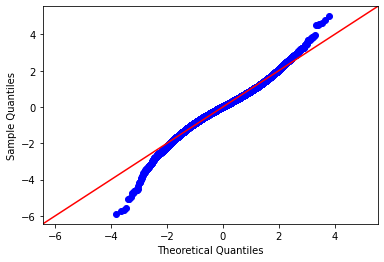

In [106]:
fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)

Note: There appears to be some issues with the residuals not being normally distributed.

This displays a fairly pronounced 'funnel' shape: errors appear to increase as the list_price decreases and increases. This doesn't bode well for our model. Subsetting the data to remove outliers and confining the model to this restricted domain may be necessary. A log transformation or something equivalent may also be appropriate.

## Check Homoscedasticity Assumption

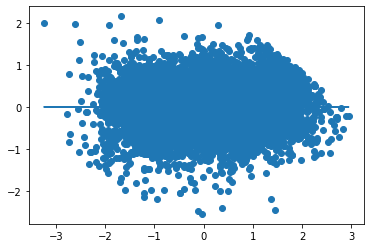

In [107]:
plt.scatter(model.predict(train[x_cols]), model.resid)
plt.plot(model.predict(train[x_cols]), [0 for i in range(len(train))])

Note: There is no strong evidence of heteroscedasticity (unequal scatter of residuals).

## Evaluate Model using sci-kit learn's cross_val_score

In [108]:
# Define X_train and y_train. As single feature need to reshape X_train into column vector
X_train = train[x_cols]
y_train = train['price']

# Create linear regression object
linreg = LinearRegression()

# Fit on training data
linreg.fit(X_train, y_train)

scores = cross_val_score(
            linreg, 
            X_train,
            y_train,
            cv=10,
            scoring="neg_mean_squared_error"
)

rmse_scores = np.sqrt(-scores)
display(rmse_scores)
display(rmse_scores.mean())
display(rmse_scores.std())

array([0.45060312, 0.44011658, 0.41192896, 0.43659835, 0.43443611,
       0.43354976, 0.4334492 , 0.43896622, 0.43961554, 0.42318315])

0.43424469958006656

0.009900797312955366

# Model 2: Select Features

Note: Removed features based on linear analysis performed above
- yr_built features
- sqft_lot
- floors
- basement_1
- grade_3
- grade_4
- grade_12

In [109]:
model_2_df = df[['price',
 'bedrooms',
 'bathrooms',
 'sqft_living',
 'waterfront_1',
 'view_1',
 'condition_2',
 'condition_3',
 'condition_4',
 'condition_5',
 'renovated_1',
 'grade_11',
 'grade_5',
 'grade_6',
 'grade_7',
 'grade_8',
 'grade_9',
 'rank_10',
 'rank_2',
 'rank_3',
 'rank_4',
 'rank_5',
 'rank_6',
 'rank_7',
 'rank_8',
 'rank_9']]

In [110]:
model_2_df.head()

,price,bedrooms,bathrooms,sqft_living,waterfront_1,view_1,condition_2,condition_3,condition_4,condition_5,...,grade_9,rank_10,rank_2,rank_3,rank_4,rank_5,rank_6,rank_7,rank_8,rank_9
0,-1.448625,-0.234561,-1.716352,-1.110551,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
1,-1.612827,-1.699959,-1.716352,-1.867599,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0.032464,-0.234561,0.437524,0.377035,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
3,-1.317501,-0.234561,-1.716352,-0.860609,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
4,-2.015709,-1.699959,-1.716352,-1.926929,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1


In [111]:
# Defining the problem
outcome = 'price'
x_cols = list(model_2_df.columns)
x_cols.remove(outcome)

In [112]:
print(len(train), len(test))
train.head()

14658 4887


,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront_1,view_1,condition_2,condition_3,...,basement_1,rank_10,rank_2,rank_3,rank_4,rank_5,rank_6,rank_7,rank_8,rank_9
15597,-0.331820,-1.699959,-1.716352,-2.245941,-0.234606,-0.922555,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
16938,1.171713,-0.234561,0.717367,0.314846,1.003701,-0.922555,0,1,0,1,...,1,0,0,0,1,0,0,0,0,0
17044,-0.303628,-1.699959,-1.716352,-1.245228,0.077273,-0.922555,0,1,0,1,...,0,0,0,0,1,0,0,0,0,0
1090,1.646667,0.805156,0.437524,1.091661,-0.396929,1.052297,0,1,0,1,...,1,0,0,0,0,1,0,0,0,0
4027,0.521718,0.805156,-0.229981,0.091438,-0.822874,0.232660,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0


In [113]:
test.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront_1,view_1,condition_2,condition_3,...,basement_1,rank_10,rank_2,rank_3,rank_4,rank_5,rank_6,rank_7,rank_8,rank_9
89,-0.891815,-0.234561,-0.229981,0.389295,1.037418,-0.922555,0,0,0,1,...,1,0,0,0,0,0,0,0,0,1
1506,0.805935,0.805156,0.717367,0.826992,0.051503,1.052297,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
20105,-0.490010,-1.699959,-0.639414,0.327404,0.568555,-0.922555,0,0,0,1,...,1,0,0,0,0,0,0,0,1,0
5999,1.309956,-0.234561,-0.229981,0.077674,0.440767,-0.922555,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5271,-1.545769,-0.234561,-0.639414,-1.512018,0.454739,-0.922555,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [114]:
# Fitting the actual model
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.813
Model:                            OLS   Adj. R-squared:                  0.813
Method:                 Least Squares   F-statistic:                     2549.
Date:                Tue, 13 Apr 2021   Prob (F-statistic):               0.00
Time:                        13:21:06   Log-Likelihood:                -8521.1
No. Observations:               14658   AIC:                         1.709e+04
Df Residuals:                   14632   BIC:                         1.729e+04
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.8366      0.102      8.192      0.000       0.636       1.037
bedrooms        -0.0211      0.005     -4.345      0.000      -0.031      -0.012
bathrooms        0.0003      0.006      0.054      0.957      -0.011       0.011
sqft_living      0.3752      0.007     55.154      0.000       0.362       0.389
waterfront_1     0.9692      0.061     15.976      0.000       0.850       1.088
view_1           0.3953      0.014     28.523      0.000       0.368       0.423
condition_2      0.1546      0.108      1.436      0.151      -0.056       0.366
condition_3      0.4496      0.100      4.487      0.000       0.253       0.646
condition_4      0.5199      0.100      5.185      0.000       0.323       0.716
condition_5      0.7002      0.101      6.944      0.000       0.503       0.898
renovated_1      0.2252      0.020     11.051      0.000       0.185       0.265
grade_11         0.1993      0.059      3.386      0.001       0.084       0.315
grade_5         -0.9331      0.043    -21.939      0.000      -1.017      -0.850
grade_6         -0.7093      0.026    -27.494      0.000      -0.760      -0.659
grade_7         -0.5626      0.021    -26.408      0.000      -0.604      -0.521
grade_8         -0.4073      0.020    -20.271      0.000      -0.447      -0.368
grade_9         -0.1221      0.021     -5.805      0.000      -0.163      -0.081
rank_10         -1.8600      0.019    -96.912      0.000      -1.898      -1.822
rank_2          -0.2251      0.019    -12.010      0.000      -0.262      -0.188
rank_3          -0.4623      0.017    -27.281      0.000      -0.495      -0.429
rank_4          -0.3416      0.018    -19.510      0.000      -0.376      -0.307
rank_5          -0.7467      0.020    -38.122      0.000      -0.785      -0.708
rank_6          -0.9529      0.018    -52.612      0.000      -0.988      -0.917
rank_7          -1.0328      0.018    -58.883      0.000      -1.067      -0.998
rank_8          -1.4915      0.018    -83.654      0.000      -1.526      -1.457
rank_9          -1.7964      0.018    -99.315      0.000      -1.832      -1.761
==============================================================================
Omnibus:                      545.375   Durbin-Watson:                   2.021
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1633.999
Skew:                          -0.057   Prob(JB):                         0.00
Kurtosis:                       4.632   Cond. No.                         96.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Remove Uninfluential Features

In [115]:
# Extract the p-value table from the summary and use it to subset our features
summary = model.summary()
p_table = summary.tables[1]
p_table = pd.DataFrame(p_table.data)
p_table.columns = p_table.iloc[0]
p_table = p_table.drop(0)
p_table = p_table.set_index(p_table.columns[0])
p_table['P>|t|'] = p_table['P>|t|'].astype(float)
x_cols = list(p_table[p_table['P>|t|'] < 0.05].index)
x_cols.remove('Intercept')
print(len(p_table), len(x_cols))
print(x_cols[:5])
p_table.head()

26 23
['bedrooms', 'sqft_living', 'waterfront_1', 'view_1', 'condition_3']


,coef,std err,t,P>|t|,[0.025,0.975]
,,,,,,
Intercept,0.8366,0.102,8.192,0.000,0.636,1.037
bedrooms,-0.0211,0.005,-4.345,0.000,-0.031,-0.012
bathrooms,0.0003,0.006,0.054,0.957,-0.011,0.011
sqft_living,0.3752,0.007,55.154,0.000,0.362,0.389
waterfront_1,0.9692,0.061,15.976,0.000,0.850,1.088


In [116]:
# Refit model with subset features
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.813
Model:                            OLS   Adj. R-squared:                  0.813
Method:                 Least Squares   F-statistic:                     2770.
Date:                Tue, 13 Apr 2021   Prob (F-statistic):               0.00
Time:                        13:21:06   Log-Likelihood:                -8522.1
No. Observations:               14658   AIC:                         1.709e+04
Df Residuals:                   14634   BIC:                         1.727e+04
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.9691      0.044     22.148      0.000       0.883       1.055
bedrooms        -0.0211      0.005     -4.356      0.000      -0.031      -0.012
sqft_living      0.3753      0.006     60.937      0.000       0.363       0.387
waterfront_1     0.9695      0.061     15.980      0.000       0.851       1.088
view_1           0.3952      0.014     28.539      0.000       0.368       0.422
condition_3      0.3167      0.038      8.265      0.000       0.242       0.392
condition_4      0.3870      0.039     10.033      0.000       0.311       0.463
condition_5      0.5673      0.040     14.184      0.000       0.489       0.646
renovated_1      0.2251      0.020     11.047      0.000       0.185       0.265
grade_11         0.1995      0.059      3.390      0.001       0.084       0.315
grade_5         -0.9369      0.042    -22.139      0.000      -1.020      -0.854
grade_6         -0.7094      0.025    -27.834      0.000      -0.759      -0.659
grade_7         -0.5626      0.021    -26.486      0.000      -0.604      -0.521
grade_8         -0.4072      0.020    -20.273      0.000      -0.447      -0.368
grade_9         -0.1219      0.021     -5.799      0.000      -0.163      -0.081
rank_10         -1.8595      0.019    -96.905      0.000      -1.897      -1.822
rank_2          -0.2246      0.019    -11.989      0.000      -0.261      -0.188
rank_3          -0.4619      0.017    -27.281      0.000      -0.495      -0.429
rank_4          -0.3413      0.018    -19.503      0.000      -0.376      -0.307
rank_5          -0.7461      0.020    -38.141      0.000      -0.784      -0.708
rank_6          -0.9524      0.018    -52.621      0.000      -0.988      -0.917
rank_7          -1.0322      0.018    -58.865      0.000      -1.067      -0.998
rank_8          -1.4910      0.018    -83.799      0.000      -1.526      -1.456
rank_9          -1.7960      0.018    -99.430      0.000      -1.831      -1.761
==============================================================================
Omnibus:                      541.485   Durbin-Watson:                   2.021
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1610.852
Skew:                          -0.060   Prob(JB):                         0.00
Kurtosis:                       4.620   Cond. No.                         30.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Evaluate Model using sci-kit learn's cross_val_score

In [117]:
# Define X_train and y_train. As single feature need to reshape X_train into column vector
X_train = train[x_cols]
y_train = train['price']

# Create linear regression object
linreg = LinearRegression()

# Fit on training data
linreg.fit(X_train, y_train)

scores = cross_val_score(
            linreg, 
            X_train,
            y_train,
            cv=10,
            scoring="neg_mean_squared_error"
)

rmse_scores = np.sqrt(-scores)
display(rmse_scores)
display(rmse_scores.mean())
display(rmse_scores.std())

array([0.45773288, 0.42896016, 0.4065671 , 0.44431474, 0.42988143,
       0.44308771, 0.43425245, 0.43805142, 0.4342814 , 0.41747722])

0.43346064937099194

0.013541811892605561

# Check the Normality Assumption

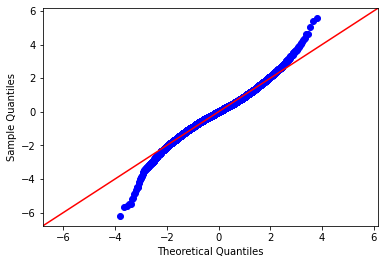

In [118]:
fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)

## Check Homoscedasticity Assumption

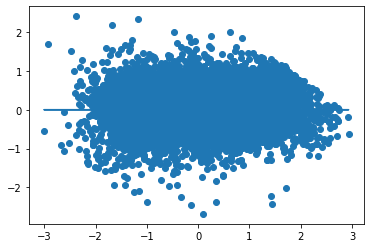

In [119]:
plt.scatter(model.predict(train[x_cols]), model.resid)
plt.plot(model.predict(train[x_cols]), [0 for i in range(len(train))])

## Investigate Multicollinearity

In [120]:
# Your code here
X = model_2_df[x_cols]
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
list(zip(x_cols, vif))

[('bedrooms', 1.836186737083057),
 ('sqft_living', 2.9444433996279322),
 ('waterfront_1', 1.0500552538591763),
 ('view_1', 1.2088559626043767),
 ('condition_3', 20.58791480769451),
 ('condition_4', 9.139683752498886),
 ('condition_5', 3.501554721422346),
 ('renovated_1', 1.0562957544632172),
 ('grade_11', 1.102385646767216),
 ('grade_5', 1.4302149667716315),
 ('grade_6', 4.478715248616211),
 ('grade_7', 13.501372885264127),
 ('grade_8', 8.127629335059371),
 ('grade_9', 3.5837877692916513),
 ('rank_10', 2.2454486422022395),
 ('rank_2', 2.0151630597054018),
 ('rank_3', 2.8811108396762752),
 ('rank_4', 2.699497117551735),
 ('rank_5', 2.010602599198369),
 ('rank_6', 2.5245602396091793),
 ('rank_7', 2.873593381379422),
 ('rank_8', 2.7276989822174005),
 ('rank_9', 2.4856840307182857)]

## Perform Another Round of Feature Selection

In [121]:
vif_scores = list(zip(x_cols, vif))
x_cols = [x for x,vif in vif_scores if vif < 5]
print(len(vif_scores), len(x_cols))

23 19


In [122]:
# Refit model with subset features
predictors = '+'.join(x_cols)
formula = outcome + "~" + predictors
model = ols(formula=formula, data=train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.802
Model:                            OLS   Adj. R-squared:                  0.802
Method:                 Least Squares   F-statistic:                     3125.
Date:                Tue, 13 Apr 2021   Prob (F-statistic):               0.00
Time:                        13:21:07   Log-Likelihood:                -8941.0
No. Observations:               14658   AIC:                         1.792e+04
Df Residuals:                   14638   BIC:                         1.807e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.8879      0.015     61.004      0.000       0.859       0.916
bedrooms        -0.0413      0.005     -8.426      0.000      -0.051      -0.032
sqft_living      0.4491      0.006     79.355      0.000       0.438       0.460
waterfront_1     0.9772      0.062     15.658      0.000       0.855       1.099
view_1           0.4220      0.014     29.716      0.000       0.394       0.450
condition_5      0.1994      0.014     14.583      0.000       0.173       0.226
renovated_1      0.1872      0.021      8.967      0.000       0.146       0.228
grade_11         0.5146      0.058      8.809      0.000       0.400       0.629
grade_5         -0.3697      0.037    -10.108      0.000      -0.441      -0.298
grade_6         -0.1497      0.014    -11.002      0.000      -0.176      -0.123
grade_9          0.2643      0.013     20.872      0.000       0.239       0.289
rank_10         -1.9421      0.019    -99.892      0.000      -1.980      -1.904
rank_2          -0.2354      0.019    -12.266      0.000      -0.273      -0.198
rank_3          -0.4987      0.017    -28.904      0.000      -0.533      -0.465
rank_4          -0.3900      0.018    -21.815      0.000      -0.425      -0.355
rank_5          -0.8159      0.020    -41.069      0.000      -0.855      -0.777
rank_6          -1.0319      0.018    -56.440      0.000      -1.068      -0.996
rank_7          -1.1037      0.018    -62.040      0.000      -1.139      -1.069
rank_8          -1.5632      0.018    -86.848      0.000      -1.599      -1.528
rank_9          -1.8674      0.018   -101.716      0.000      -1.903      -1.831
==============================================================================
Omnibus:                      468.007   Durbin-Watson:                   2.020
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1261.877
Skew:                          -0.065   Prob(JB):                    9.71e-275
Kurtosis:                       4.431   Cond. No.                         22.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [123]:
# Define X_train and y_train. As single feature need to reshape X_train into column vector
X_train = train[x_cols]
y_train = train['price']

# Create linear regression object
linreg = LinearRegression()

# Fit on training data
linreg.fit(X_train, y_train)

scores = cross_val_score(
            linreg, 
            X_train,
            y_train,
            cv=10,
            scoring="neg_mean_squared_error"
)

rmse_scores = np.sqrt(-scores)
display(rmse_scores)
display(rmse_scores.mean())
display(rmse_scores.std())

array([0.46588233, 0.44638243, 0.42304349, 0.45631497, 0.44679883,
       0.44316379, 0.44810366, 0.44832817, 0.44655239, 0.43376364])

0.44583336978900573

0.010941377090110047

In [124]:
# Save model
#tuple_objects = (linreg, X_train, y_train)
#pickle.dump(tuple_objects, open('model_3.pkl','wb'))

# Predictions with test data

In [125]:
test.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront_1,view_1,condition_2,condition_3,...,basement_1,rank_10,rank_2,rank_3,rank_4,rank_5,rank_6,rank_7,rank_8,rank_9
89,-0.891815,-0.234561,-0.229981,0.389295,1.037418,-0.922555,0,0,0,1,...,1,0,0,0,0,0,0,0,0,1
1506,0.805935,0.805156,0.717367,0.826992,0.051503,1.052297,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
20105,-0.490010,-1.699959,-0.639414,0.327404,0.568555,-0.922555,0,0,0,1,...,1,0,0,0,0,0,0,0,1,0
5999,1.309956,-0.234561,-0.229981,0.077674,0.440767,-0.922555,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5271,-1.545769,-0.234561,-0.639414,-1.512018,0.454739,-0.922555,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [126]:
len(test)

4887

In [127]:
# Fitting the actual model
outcome = 'price'
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=test).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.806
Model:                            OLS   Adj. R-squared:                  0.806
Method:                 Least Squares   F-statistic:                     1067.
Date:                Tue, 13 Apr 2021   Prob (F-statistic):               0.00
Time:                        13:21:07   Log-Likelihood:                -2901.2
No. Observations:                4887   AIC:                             5842.
Df Residuals:                    4867   BIC:                             5972.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.8878      0.025     36.136      0.000       0.840       0.936
bedrooms        -0.0323      0.009     -3.781      0.000      -0.049      -0.016
sqft_living      0.4366      0.010     44.147      0.000       0.417       0.456
waterfront_1     1.2378      0.148      8.337      0.000       0.947       1.529
view_1           0.4437      0.024     18.541      0.000       0.397       0.491
condition_5      0.1759      0.024      7.393      0.000       0.129       0.223
renovated_1      0.2253      0.037      6.144      0.000       0.153       0.297
grade_11         0.5770      0.085      6.827      0.000       0.411       0.743
grade_5         -0.3831      0.058     -6.605      0.000      -0.497      -0.269
grade_6         -0.1658      0.024     -6.815      0.000      -0.213      -0.118
grade_9          0.2714      0.021     12.654      0.000       0.229       0.313
rank_10         -1.9212      0.033    -58.469      0.000      -1.986      -1.857
rank_2          -0.2339      0.033     -7.084      0.000      -0.299      -0.169
rank_3          -0.4733      0.029    -16.270      0.000      -0.530      -0.416
rank_4          -0.3644      0.030    -12.140      0.000      -0.423      -0.306
rank_5          -0.8619      0.034    -25.587      0.000      -0.928      -0.796
rank_6          -1.0051      0.031    -32.795      0.000      -1.065      -0.945
rank_7          -1.1354      0.030    -37.666      0.000      -1.194      -1.076
rank_8          -1.5655      0.030    -52.159      0.000      -1.624      -1.507
rank_9          -1.8331      0.031    -58.708      0.000      -1.894      -1.772
==============================================================================
Omnibus:                      187.319   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              572.227
Skew:                          -0.021   Prob(JB):                    5.53e-125
Kurtosis:                       4.676   Cond. No.                         30.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [128]:
len(x_cols)

19

## Interpret results

- Adj. R-squared:	0.800 = model adequately predicts sales price
- No p-values > 0.05 = features statistically significant

- bedrooms surprsingly had a negative impact on price
- having a waterfront had the highest impact on price
- sqft_living, view, rennovation had a postiive impact on price
- higher grades and conditions have positive impacts on price
- zip ranks negatively impacted price, but better rankings were less impactful

In [129]:
# Define X_train and y_train. As single feature need to reshape X_train into column vector
X_test = test[x_cols]
y_test = test['price']

# Create linear regression object
linreg = LinearRegression()

# Fit on training data
linreg.fit(X_test, y_test)

scores = cross_val_score(
            linreg, 
            X_test,
            y_test,
            cv=10,
            scoring="neg_mean_squared_error"
)

rmse_scores = np.sqrt(-scores)
display(rmse_scores)
display(rmse_scores.mean())
display(rmse_scores.std())

array([0.46371765, 0.40569556, 0.43880488, 0.4591248 , 0.43128227,
       0.43800962, 0.4432375 , 0.45786626, 0.42246383, 0.43906535])

0.4399267735060561

0.016806219822520622

Note: 
Train
- Mean: 0.445487007351384
- Std: 0.012876930669861342

Based on a rule of thumb, it can be said that RMSE values between 0.2 and 0.5 shows that the model can relatively predict the data accurately.

## Check the Normality Assumption

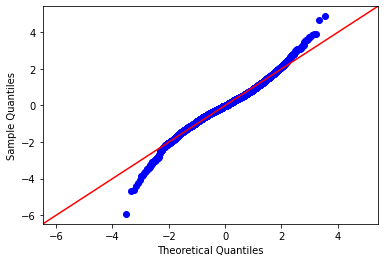

In [130]:
fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)

## Check Homoscedasticity Assumption

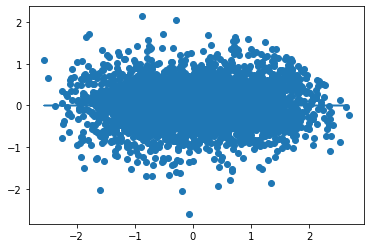

In [131]:
plt.scatter(model.predict(test[x_cols]), model.resid)
plt.plot(model.predict(test[x_cols]), [0 for i in range(len(test))])